# 多层感知机的从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

In [6]:
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 激活函数

In [7]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

In [8]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return H@W2 + b2

## 损失函数

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

In [10]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

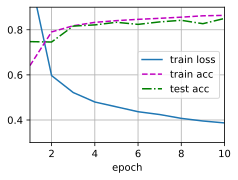

In [11]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

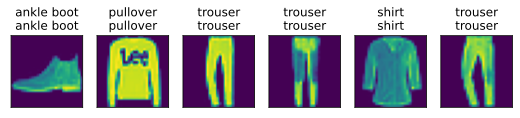

In [12]:
d2l.predict_ch3(net, test_iter)

# 多层感知机的简洁实现

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

In [14]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [16]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

## 训练

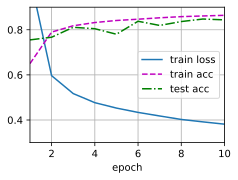

In [17]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 模型选择、欠拟合和过拟合

当我们⽐较训练和验证误差时，我们要注意两种常⻅的情况。⾸先，我们要注意这样的情况：训练误差和验证误差都很严重，但它们之间仅有⼀点差距。如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能⼒不⾜），⽆法捕获试图学习的模式。此外，由于我们的训练和验证误差之间的泛化误差很⼩，我们有理由相信可以⽤⼀个更复杂的模型降低训练误差。这种现象被称为⽋拟合（underfitting）。

当我们的训练误差明显低于验证误差时要⼩⼼，这表明严重的过拟合（overfitting）。注意，过拟合并不总是⼀件坏事。特别是在深度学习领域，众所周知，最好的预测模型在训练数据上的表现往往⽐在保留（验证）数据上好得多。最终，我们通常更关⼼验证误差，⽽不是训练误差和验证误差之间的差距。

## 多项式回归

通过多项式拟合来探索这些概念

In [20]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

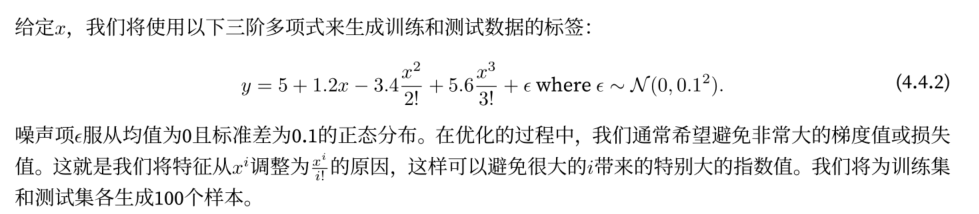

### 生成数据集

In [21]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 平方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n) = (n - 1)!
# labels的维度：(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [25]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                                           for x in [true_w, features, poly_features, labels]]

In [26]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8240],
         [-1.1419]]),
 tensor([[ 1.0000e+00, -8.2400e-01,  3.3949e-01, -9.3246e-02,  1.9209e-02,
          -3.1656e-03,  4.3474e-04, -5.1175e-05,  5.2710e-06, -4.8259e-07,
           3.9765e-08, -2.9788e-09,  2.0454e-10, -1.2965e-11,  7.6307e-13,
          -4.1918e-14,  2.1588e-15, -1.0464e-16,  4.7901e-18, -2.0774e-19],
         [ 1.0000e+00, -1.1419e+00,  6.5193e-01, -2.4814e-01,  7.0835e-02,
          -1.6177e-02,  3.0787e-03, -5.0220e-04,  7.1681e-05, -9.0945e-06,
           1.0385e-06, -1.0780e-07,  1.0258e-08, -9.0099e-10,  7.3487e-11,
          -5.5941e-12,  3.9924e-13, -2.6816e-14,  1.7011e-15, -1.0224e-16]]),
 tensor([2.2689, 0.0447]))

## 对模型进行训练和测试

In [30]:
# 评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [31]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', 
                            yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 正常情况

我们将⾸先使⽤三阶多项式函数，它与数据⽣成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失。学习到的模型参数也接近真实值w = [5,1.2,−3.4,5.6]。

weight: [[ 4.9951706  1.2069819 -3.395906   5.592408 ]]


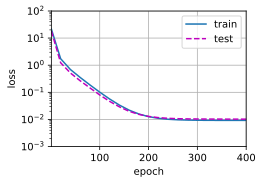

In [32]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### 欠拟合

再看看线性函数拟合，减少该模型的训练损失相对困难。在最后⼀个迭代周期完成后，训练损失仍然很⾼。当⽤来拟合⾮线性模式（如这⾥的三阶多项式函数）时，线性模型容易⽋拟合。

weight: [[3.4344585 3.752998 ]]


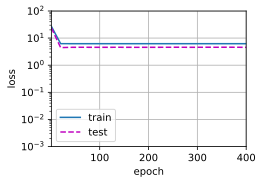

In [33]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

### 过拟合

尝试使⽤⼀个阶数过⾼的多项式来训练模型。在这种情况下，没有⾜够的数据⽤于学到⾼阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很⾼。结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.980946    1.2816924  -3.324759    5.1723804  -0.2633658   1.3198746
   0.24016789 -0.02837173 -0.11202689  0.01732526 -0.03603285 -0.18035242
  -0.11634814 -0.03375716  0.0334663  -0.05258147  0.1274413  -0.0479625
   0.19361925  0.01035745]]


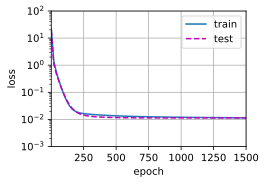

In [34]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :],poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)